In [84]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

info_type = "hidden_states"
layer = "31"
file_name = "ablation_discret.csv"

humaneval_file_path = os.path.join(
    "humaneval", "codellama-13b-Instruct", info_type, layer, file_name
)
mbpp_file_path = os.path.join(
    "mbpp", "codellama-13b-Instruct", info_type, layer, file_name
)
code_search_net_java_file_path = os.path.join(
    "code_search_net_java",
    "codellama-13b-Instruct_with_semantic",
    info_type,
    layer,
    file_name,
)
tl_code_sum_file_path = os.path.join(
    "tl_code_sum", "codellama-13b-Instruct_with_semantic", info_type, layer, file_name
)

truthful_qa_file_path = os.path.join("truthful_qa", "llama2_7B_with_semantics", info_type, layer, file_name)
sst2_file_path = os.path.join("sst2", "llama2_7B", info_type, layer, file_name)
advglue_file_path = os.path.join("advglue++", "llama2_7B", info_type, layer, file_name)


def get_df(file_path):
    df = pd.read_csv(file_path)
    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    df['PCA_dim'] = pd.to_numeric(df['PCA_dim'], errors='coerce')

    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    return df

df_humaneval = get_df(humaneval_file_path)
df_mbpp = get_df(mbpp_file_path)
df_code_search_net_java = get_df(code_search_net_java_file_path)
df_tl_code_sum = get_df(tl_code_sum_file_path)

df_truthful_qa = get_df(truthful_qa_file_path)

df_sst2 = get_df(sst2_file_path)
df_advglue = get_df(advglue_file_path)

datasets = {
    'TruthfulQA': df_truthful_qa,
    'SST-2': df_sst2,
    'AdvGLUE++': df_advglue,
    'HumanEval': df_humaneval,
    'MBPP': df_mbpp,
    'CodeSearchNet-Java': df_code_search_net_java,
    'TL-CodeSum': df_tl_code_sum,
    
}


In [85]:
def map_to_segments(x, breakpoints=[100, 1000, 10000], scales=[0.4, 0.35, 0.05, 0.2]):
    """
    Maps a value 'x' to a new scale with three breakpoints, dividing the scale into four segments.

    :param x: Original x-value.
    :param breakpoints: A list of breakpoints.
    :param scales: The fraction of the axis each segment should occupy; must sum to 1.
    :return: New x-value mapped to the custom scale.
    """
    assert sum(scales) == 1, "Scales must sum to 1"

    if x <= breakpoints[0]:
        return x * scales[0] / breakpoints[0]
    elif x <= breakpoints[1]:
        return scales[0] + (x - breakpoints[0]) * scales[1] / (breakpoints[1] - breakpoints[0])
    elif x <= breakpoints[2]:
        segment_start = scales[0] + scales[1]
        return segment_start + (x - breakpoints[1]) * scales[2] / (breakpoints[2] - breakpoints[1])
    else:
        segment_start = scales[0] + scales[1] + scales[2]
        adjusted_x = x - breakpoints[2]
        max_value = 100000  # Define an upper limit for x, adjust as necessary
        adjusted_max_value = max_value - breakpoints[2]
        return segment_start + adjusted_x * scales[3] / adjusted_max_value


/tmp/ipykernel_279377/3792586189.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['abstract_state_num'] = pd.to_numeric(df_filtered['abstract_state_num'], errors='coerce')
/tmp/ipykernel_279377/3792586189.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by='abstract_state_num', inplace=True)
/tmp/ipykernel_279377/3792586189.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

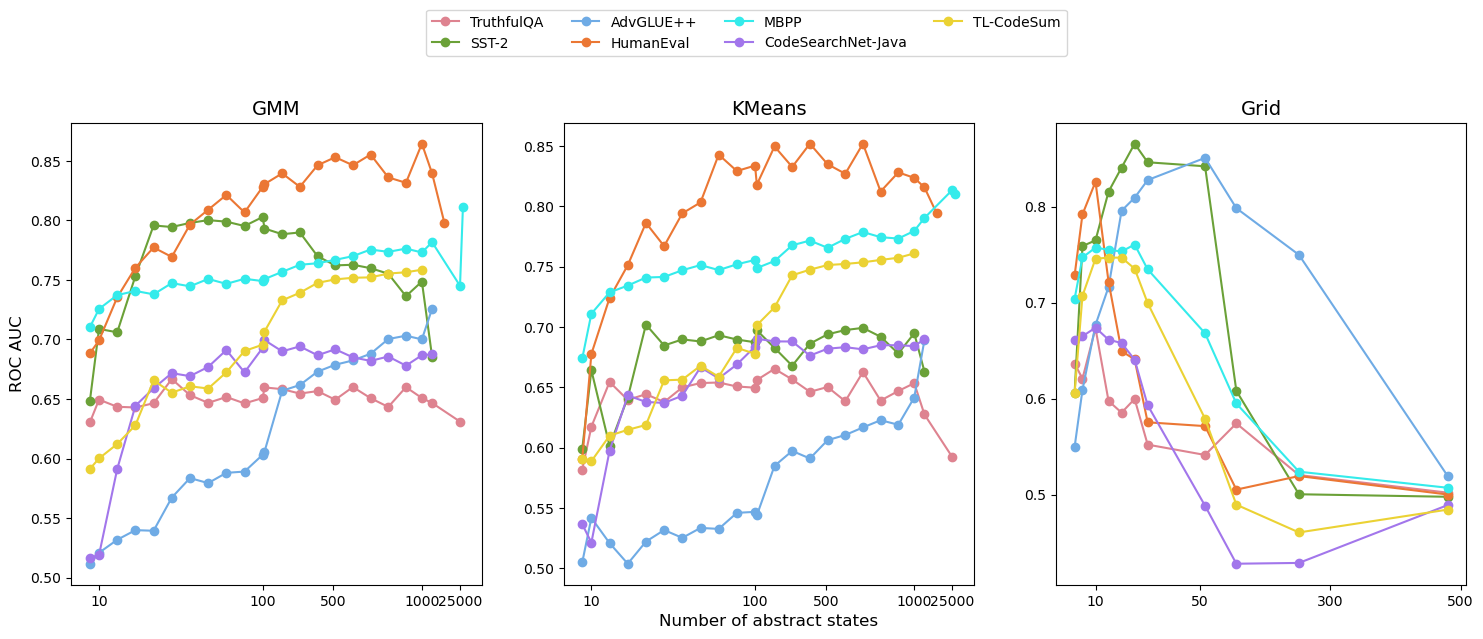

In [86]:
dataset_colors = {
    'TruthfulQA': '#de8390',  # Pink
    'SST-2': '#6ba138',  # Green
    'AdvGLUE++': '#6fabe5',  # Blue
    'CodeSearchNet-Java': '#a276eb',  # Purple, new color
    'TL-CodeSum': '#ebd234',  # Yellow, new color
    'HumanEval': '#eb7734',  # Orange, new color
    'MBPP': '#34ebeb',  # Cyan, new color
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
methods = ['GMM', 'KMeans', 'Grid']
x_ticks_labels = [10, 100, 500, 1000, 25000]

grid_x_ticks_labels = [10, 50, 300, 500]

# Apply the map_to_segments function to scale these tick labels
x_ticks_scaled = list(map(map_to_segments, x_ticks_labels))

grid_ticks_scaled = []
for grid_x in grid_x_ticks_labels:
    scaled_x = map_to_segments(grid_x, breakpoints=[50, 300, 500], scales=[0.25, 0.25, 0.25, 0.25])
    grid_ticks_scaled.append(scaled_x)
    

for i, method in enumerate(methods):
    ax = axes[i]
    ax.set_title(f'{method}')
    # set title font size
    ax.title.set_fontsize(14)
    if i == 1:
        ax.set_xlabel('Number of abstract states', fontsize=12)
    if i == 0:
        ax.set_ylabel('ROC AUC', fontsize=12)

    for dataset_name, df in datasets.items():
        df_filtered = df[(df['abstract_method'] == method) & df['abstract_state_num'].notnull()]
        df_filtered['abstract_state_num'] = pd.to_numeric(df_filtered['abstract_state_num'], errors='coerce')
        df_filtered.sort_values(by='abstract_state_num', inplace=True)

        # Apply custom scaling to abstract_state_num
        if i == 2:
            scaled_x = df_filtered['abstract_state_num'].apply(map_to_segments, breakpoints=[50, 300, 500], scales=[0.25, 0.25, 0.25, 0.25])
        else:
            scaled_x = df_filtered['abstract_state_num'].apply(map_to_segments)

        ax.plot(scaled_x, df_filtered['aucroc'], color=dataset_colors[dataset_name], marker='o', linestyle='-', label=dataset_name)

    # Set custom x-axis ticks and labels
    if i == 2:
        ax.set_xticks(grid_ticks_scaled)
        ax.set_xticklabels(grid_x_ticks_labels, fontsize=10)
        
    else:
        ax.set_xticks(x_ticks_scaled)
        ax.set_xticklabels(x_ticks_labels, fontsize=10)
    

# plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(-0.5, 1.25), fontsize=10, markerscale=0)
# plt.subplots_adjust(wspace=0.2, hspace=0.6)  # Adjusted spacing
handles, labels = axes[0].get_legend_handles_labels()  # Assuming all subplots share the same legend info

# Using fig.legend() to explicitly attach the legend to the figure
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.08), fontsize=10, markerscale=0)

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom margin if necessary
# plt.tight_layout()
plt.savefig('plot/ablation_discret.pdf')
plt.show()

